In [104]:
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'white', color_codes = True)
import numpy as np
from scipy.sparse import csr_matrix

In [2]:
import pandas_profiling
import eli5

/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [105]:
from sklearn import preprocessing
import lightgbm as lgb
import scipy.stats as st
import statsmodels.formula.api as smf

In [106]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import (roc_auc_score,accuracy_score, classification_report,
confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve)
from sklearn.model_selection import train_test_split,GridSearchCV

# Part 1

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.


In [107]:
df = pd.read_json('logins.json')

In [108]:
df.isnull().sum()

login_time    0
dtype: int64

In [109]:
df['login_time']=pd.to_datetime(df['login_time'])

In [110]:
count = np.ones(df.shape[0],dtype =np.int )

In [111]:
df_count = pd.DataFrame(count, index =df['login_time'], columns=['count'])
df_count.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [112]:
df_count = df_count.resample('15min',how='sum')
df_count.head()

/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


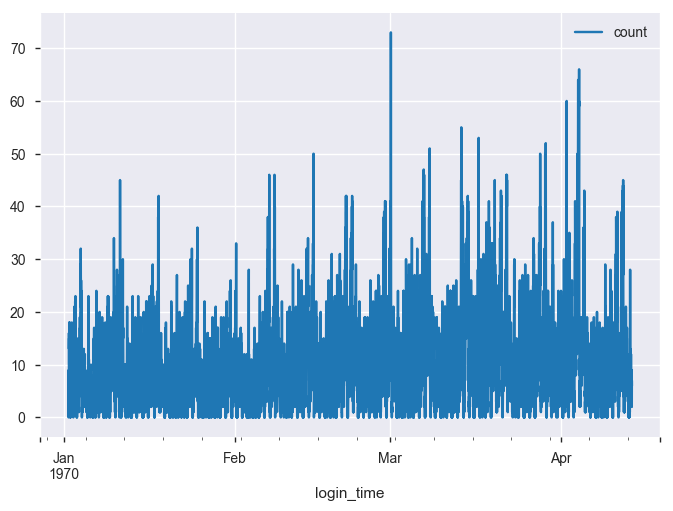

In [34]:
df_count.plot()
plt.show()

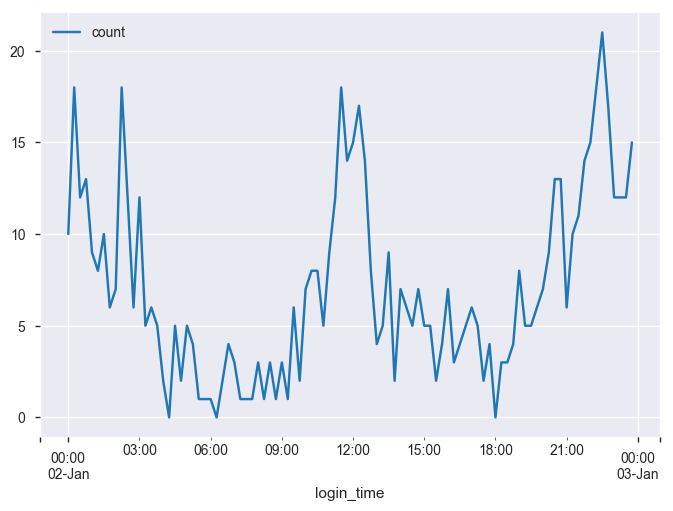

In [39]:
# Daily plot
df_count.loc['1970-01-02':'1970-01-02'].plot()
plt.show()

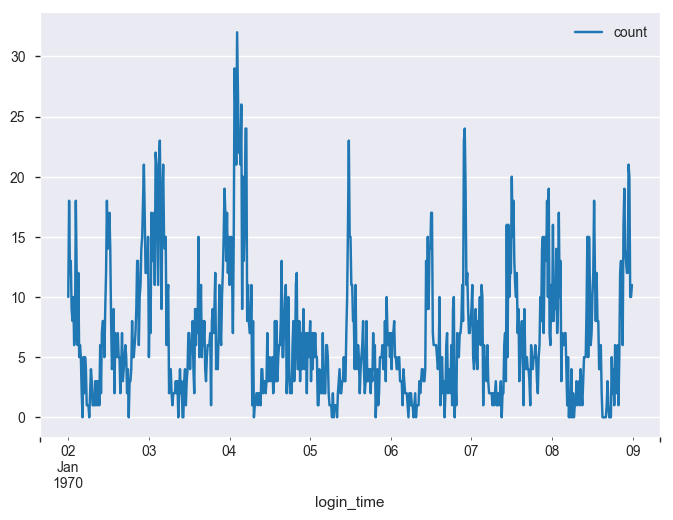

In [42]:
# Weekly plot
df_count.loc['1970-01-02':'1970-01-08'].plot()
plt.show()

### Report 

A seasonal pattern is observed: we can see a daily cycle from the weekly plot. From the daily plot, we find that the demanding is strong (spike) around noon and night. 

# Part 2

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

### Report:

We can use the flow rate of cars passing trough the toll bridge as the metric. In order to measure the flow rate of cars, we can use sensors to count the car passing (or processing the camera data.) 

As a result, we can compare the average flow rate of cars before reimbursing all toll costs and after reimbursing all toll costs. A statistic t-test will be conducted to verify the significance of the observation; the H0 hypthosis is average flow rate of cars after reimbursing all toll costs is equal to before reimbursing all toll costs and H1 hypthosis is average flow rate of cars after reimbursing all toll costs is bigger than before reimbursing all toll costs 

If the p-value is smaller than 0.05, we will infer that it is statistically significant and the reimbursing all toll costs improve participation of drivers. Otherwise, we can not reject the H0 hypthosis and reimbursing all toll costs do not have a significant effect on participation.

# Part3 

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


### Report 1. 
We do exploratory analysis, and/or visualizations by pandas_profiling which gives descriptive statistics and distributions for each column.

In the cleaning steps: 

we encode category variables to numerics; 

we fill the missing values of 'phone' with 'other type' (use 2 to represent others), and 'avg_rating_by_driver' and 'avg_rating_of_driver' with their mean;

we transform 'last_trip_date' and 'signup_date' as timestamps; and extract the 'day' and 'day of week' from 'signup_date' timestamp as new features('signup_date_day' and 'signup_date_dayofweek)

we creat 'active' feature from 'last_trip_date', if the sample is in the sixth month, we lable it as 'yes' otherwise 'no'.

We do the value_counts on 'active' feature and calculate the proportions: 36.5% are active users since sign-up.

In [64]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)

In [65]:
df1 =pd.DataFrame(data)

In [80]:
df1.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,signup_date_day,signup_date_dayofweek,active
0,3.67,5.0,4.7,1.10,1,2014-06-17,0.0,2014-01-25,15.4,4,1,46.2,25,5,yes
1,8.26,5.0,5.0,1.00,0,2014-05-05,1.0,2014-01-29,0.0,0,0,50.0,29,2,no
2,0.77,5.0,4.3,1.00,0,2014-01-07,0.0,2014-01-06,0.0,3,0,100.0,6,0,no
3,2.36,4.9,4.6,1.14,1,2014-06-29,0.0,2014-01-10,20.0,9,1,80.0,10,4,yes
4,3.13,4.9,4.4,1.19,2,2014-03-15,1.0,2014-01-27,11.8,14,0,82.4,27,0,no


In [66]:
df1.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
dtype: int64

In [9]:
pandas_profiling.ProfileReport(df1)

Number of variables,12
Number of observations,50000
Total Missing (%),1.5%
Total size in memory,4.2 MiB
Average record size in memory,89.0 B
Numeric,7
Categorical,4
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [67]:
df1['phone'] = df1['phone'].map({'iPhone':0, 'Android':1})

In [68]:
df1['phone'].fillna(2, inplace =True)
df1['avg_rating_by_driver'].fillna(df1['avg_rating_by_driver'].mean(), inplace =True)
df1['avg_rating_of_driver'].fillna(df1['avg_rating_of_driver'].mean(), inplace =True)

In [70]:
lbl = preprocessing.LabelEncoder()
df1['ultimate_black_user'] = lbl.fit_transform(df1['ultimate_black_user'])
df1['city'] = lbl.fit_transform(df1['city'])

In [71]:
df1['last_trip_date']=pd.to_datetime(df1['last_trip_date'])
df1['signup_date']=pd.to_datetime(df1['signup_date'])

In [72]:
df1['signup_date_day'] = df1['signup_date'].dt.day
df1['signup_date_dayofweek'] = df1['signup_date'].dt.dayofweek

In [73]:
df1['active'] = np.where (df1['last_trip_date'].dt.month == 6, 'yes','no')
df1['active'].head()

0    yes
1     no
2     no
3    yes
4     no
Name: active, dtype: object

In [39]:
df1['active'].value_counts()

no     31744
yes    18256
Name: active, dtype: int64

In [17]:
18256/50000

0.36512

### Report 2. 
Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

We choose Logistic Regression, Random forest and Gradient boosting. The Logistic Regression and Random forest capture the liner and non-liner relationship in the model respectively and Gradient boosting gives superb performance. The generalization on the test is good as well with best performance up to 84.5%.

In [75]:
y = df1['active'].map({'no':0, 'yes':1}).values

In [76]:
X = df1.drop(['signup_date','last_trip_date','active'], axis=1).values

In [94]:
feature_names = df1.drop(['signup_date','last_trip_date','active'], axis=1).columns.values

In [95]:
feature_names

array(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',
       'avg_surge', 'city', 'phone', 'surge_pct', 'trips_in_first_30_days',
       'ultimate_black_user', 'weekday_pct', 'signup_date_day',
       'signup_date_dayofweek'], dtype=object)

In [93]:
# Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.3)
model = LogisticRegression(C=10)
X_train = np.array (X_train)
y_train = np.array (y_train).ravel()
cv_folder =4
kfolder=StratifiedKFold(y_train, n_folds= cv_folder, shuffle=True, random_state=1)
grand_auc =0.0
i = 0
for train_index, test_index in kfolder:
    X_trained, X_cv = X_train[train_index], X_train[test_index]
    y_trained, y_cv = y_train[train_index], y_train[test_index]
    model.fit(X_trained, y_trained)
    preds = model.predict_proba(X_cv)[:,1]
    auc=roc_auc_score(y_cv,preds)        
    grand_auc +=auc      
    i +=1
    
grand_auc /= cv_folder
print(grand_auc)
eli5.show_weights(model, feature_names=feature_names)

0.704568096617


In [96]:
eli5.show_weights(model, feature_names=feature_names)

Weight?,Feature
+0.865,ultimate_black_user
+0.189,city
+0.101,trips_in_first_30_days
+0.012,signup_date_dayofweek
+0.007,avg_rating_of_driver
+0.006,surge_pct
+0.000,weekday_pct
-0.004,signup_date_day
-0.030,avg_dist
-0.047,avg_rating_by_driver


In [97]:
# Random forest 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.3)
model = RandomForestClassifier()
X_train = np.array (X_train)
y_train = np.array (y_train).ravel()
cv_folder =4
kfolder=StratifiedKFold(y_train, n_folds= cv_folder, shuffle=True, random_state=1)
grand_auc =0.0
i = 0
for train_index, test_index in kfolder:
    X_trained, X_cv = X_train[train_index], X_train[test_index]
    y_trained, y_cv = y_train[train_index], y_train[test_index]
    model.fit(X_trained, y_trained)
    preds = model.predict_proba(X_cv)[:,1]
    auc=roc_auc_score(y_cv,preds)        
    grand_auc +=auc      
    i +=1
    
grand_auc /= cv_folder
print(grand_auc)
eli5.show_weights(model, feature_names=feature_names)

0.793417874898


Weight,Feature
0.1894 ± 0.0080,avg_dist
0.1254 ± 0.0649,avg_rating_by_driver
0.1081 ± 0.0228,weekday_pct
0.1051 ± 0.0120,signup_date_day
0.0741 ± 0.0115,avg_rating_of_driver
0.0730 ± 0.0262,surge_pct
0.0721 ± 0.0156,trips_in_first_30_days
0.0640 ± 0.0084,city
0.0634 ± 0.0073,signup_date_dayofweek
0.0553 ± 0.0487,avg_surge


In [100]:
# Gradient boosting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.3)
model = XGBClassifier()
X_train = np.array (X_train)
y_train = np.array (y_train).ravel()
cv_folder =4
kfolder=StratifiedKFold(y_train, n_folds= cv_folder, shuffle=True, random_state=1)
grand_auc =0.0
i = 0
for train_index, test_index in kfolder:
    X_trained, X_cv = X_train[train_index], X_train[test_index]
    y_trained, y_cv = y_train[train_index], y_train[test_index]
    model.fit(X_trained, y_trained)
    preds = model.predict_proba(X_cv)[:,1]
    auc=roc_auc_score(y_cv,preds)        
    grand_auc +=auc      
    i +=1
    
grand_auc /= cv_folder
print(grand_auc)

0.840096274577


In [101]:
# make predict on the test data 
preds = model.predict_proba(X_test)[:,1]
auc=roc_auc_score(y_test,preds)   
auc

0.84527446265796491

### Report 3. 

From the logistic regression model, the feature importance tells us if it is a ultimate_black_user(took an Ultimate Black in their first 30 days), it contributes to 86.5% weight to be active in the sixth month , which is highly possible to be retained. Also the city users sigh up and if they trips_in_first_30_days can contributes to the retain.

Therefore,  we can make promote activties when users first sigh-up to ltimate Black to make the take a ride. In particular city, this promotion emay be more effective. 
